In [1]:
import os
import sqlalchemy as db
import geopandas as gpd
import pandas as pd
import osmnx
from shapely.geometry import box, LineString, Point
from IPython.display import display, HTML
import matplotlib.pyplot as plt
import numpy as np
import json
from datetime import datetime, timedelta
import math

In [2]:
POSTGRES_HOST="xxxx"
POSTGRES_PORT="xxxx"
POSTGRES_DB="xxxx"
POSTGRES_SCHEMA="xxxx"
POSTGRES_USER="xxxxx"
POSTGRES_PASSWORD="xxxxx"

In [3]:
engine = db.create_engine('postgresql://{user}:{pw}@{host}/{db}'
                           .format(user=POSTGRES_USER,
                                   pw=POSTGRES_PASSWORD,
                                   host=POSTGRES_HOST,
                                   db=POSTGRES_DB,
                                   port=POSTGRES_PORT))

In [4]:
connection = engine.connect()

# Study area of Tunisia

	Course	Distance	Coordinate
1.	91.32°	222.49 nm	N 36.311° - E 13.323°
2.	301.04°	1.31 nm	N 36.323° - E 13.300°
3.	359.25°	127.22 nm	N 38.441° - E 13.265°
4.	273.77°	205.68 nm	N 38.585° - E 8.891°
5.	183.41°	124.88 nm	N 36.508° - E 8.736°

In [5]:
min_lon =8.736
min_lat = 36.311
max_lon= 13.323
max_lat=  38.585
bbox = box(min_lon, min_lat, max_lon, max_lat)
bbox_wkt = bbox.wkt
bbox_wkt

'POLYGON ((13.323 36.311, 13.323 38.585, 8.736 38.585, 8.736 36.311, 13.323 36.311))'

In [6]:
query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((13.323 36.311, 13.323 38.585, 8.736 38.585, 8.736 36.311, 13.323 36.311))', 4326)) AND (tags -> 'seamark:type'='separation_boundary' OR tags -> 'seamark:type'='separation_line' OR tags -> 'seamark:type'='separation_zone' OR tags -> 'seamark:type'='separation_lane')"
gdf_ways = gpd.read_postgis(query, engine)
#gdf_ways = gpd.read_postgis(query, engine)
gdf_ways['tstamp']=gdf_ways['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
gdf_ways
seamark_gdf = gdf_ways
gdf_ways.explore()

## Route Segments

	N 37.191° - E 10.566°
N 37.177° - E 10.816°
2.	81.02°	16.15 nm	N 37.218° - E 11.150°
3.	15.22°	19.86 nm	N 37.537° - E 11.259°
4.	350.55°	11.31 nm	N 37.723° - E 11.220°
5.	358.96°	6.81 nm	N 37.837° - E 11.217°



In [7]:
lats_per_step = [37.191, 37.218,37.3, 37.537, 37.723, 37.837]
lons_per_step = [10.566, 10.816, 11.2, 11.259, 11.220, 11.217 ]
starttime_per_step = [datetime(2024, 5, 17, 9), datetime(2024, 5, 17, 10), datetime(2024, 5, 17, 11), datetime(2024, 5, 17, 12),datetime(2024, 5, 17, 13),datetime(2024, 5, 17, 14)]

In [8]:
    def create_route_segments():
        """
        Create relevant line segments from the nodes(coordinates) of the minimum fuel route
        """
        route_segments = []
        timestamp = []
        for i in range(len(lons_per_step) - 1):
            segment = LineString([(lons_per_step[i], lats_per_step[i]),
                                  (lons_per_step[i + 1], lats_per_step[i + 1])])
            route_segments.append(segment)

            timestamp.append(starttime_per_step[i])

        # Add LineString segments to a new GeoDataFrame
        route_segments_gdf = gpd.GeoDataFrame({'timestamp': timestamp}, geometry=route_segments, crs="EPSG:4326")
        return route_segments_gdf


In [9]:
route_segments_gdf = create_route_segments()

In [10]:
    def find_seamark_intersections( route_segments_gdf, seamark_gdf):
        """
        First, find intersection points of route segments with any seamark object.
        If any intersection is available, then iterate over each route segment and the intersection points
        to identify which route segment is getting intersected with the intersection point.
        Then, the relevant route segment is added to the list of indices of intersected route segments

        :param route_segments_gdf: geodataframe of ship route segments
        :param seamark_gdf: geodataframe of all seamark TSS objects within the bounding box of the route
        :returns: The list of route segment indices which intersects the TSS seamark objects
        """
        intersection_gdf = gpd.overlay(route_segments_gdf, seamark_gdf,
                                       how='intersection', keep_geom_type=False)

        intersected_route_indices_list = []
        for index_seg, seg in route_segments_gdf.iterrows():
            for index_in, intersecting_point in intersection_gdf.iterrows():
                # All floating point calculations are limited by the machine epsilon(round off method).
                # The intersected points are interpolated from geometries of the linestrings, and
                # they are exact only when there's a right angle. All of the DE-9IM predicates like 'intersects'
                # requires exact node. Therefore, 2 strategies can be applied in this scenario. Setting a buffer
                # or test the distance between the geometries.
                # Tolerance: 1° is approx 110km. Hence, 10^-12 of 110 km is 110 picometers.
                EPS = 1e-12
                dist = intersecting_point.geometry.distance(seg.geometry) < EPS
                if dist:
                    intersected_route_indices_list.append(index_seg)

        return intersected_route_indices_list

In [11]:
intersecting_route_node_list  = find_seamark_intersections(route_segments_gdf,gdf_ways)


In [12]:
            first_route_seg_gdf = route_segments_gdf[0:intersecting_route_node_list[0]]
            last_route_node_intersecting = intersecting_route_node_list[len(intersecting_route_node_list) - 1]
            first_node_index_of_last_route_seg = last_route_node_intersecting + 1
            last_route_seg_gdf = route_segments_gdf[first_node_index_of_last_route_seg:]

In [13]:
query = "SELECT *,linestring AS geom FROM public.ways WHERE ST_Intersects(linestring, ST_GeomFromText('POLYGON ((13.323 36.311, 13.323 38.585, 8.736 38.585, 8.736 36.311, 13.323 36.311))', 4326)) AND ( tags -> 'seamark:type'='separation_lane')"
separation_lanes_data_gdf = gpd.read_postgis(query, engine)
#gdf_ways = gpd.read_postgis(query, engine)
separation_lanes_data_gdf['tstamp']=separation_lanes_data_gdf['tstamp'].dt.strftime('%Y-%m-%d %H:%M:%S')
separation_lanes_data_gdf
separation_lanes_data_gdf.explore()

In [14]:
 def find_last_node_of_route_seg(first_route_seg_gdf):
        """
        Find the node of the route segments before the first intersecting point
        """
        last_line_geom = first_route_seg_gdf.tail(1).geometry.get_coordinates()
        last_node_geom = last_line_geom.tail(1)
        last_node = Point(last_node_geom.x, last_node_geom.y)
        return last_node

In [15]:
last_node_of_first_route_seg = find_last_node_of_route_seg(first_route_seg_gdf)

In [16]:
    def find_seperation_lane_to_follow( last_node, seperation_lanes_gdf):
        """
        The direction of the separation lane is determined by the order of the points in the linestring.
        Hence, it is assumed the nearest starting point of the separation lane
        (when in parallel and opposite directions) need to be followed.
        This is achieved by finding the distances between the route node before the first intersection and the starting
        node of the each separation lane. Then the separation lane having the minimum distance is selected.

        :param last_node: the node of the route segments before the first intersecting point
        :param seperation_lanes_gdf: geodataframe of separation lanes
        :returns: geodataframe of the separation lane need to be followed
        """
        dist_list = []
        for line in seperation_lanes_gdf.geom:
            seamark_lane_segment = line
            x, y = seamark_lane_segment.xy
            seamark_starting_node = Point(x[0], y[0])
            dist = last_node.distance(seamark_starting_node)
            dist_list.append(dist)

        min_dist_index = dist_list.index(min(dist_list))
        seperation_lane_gdf = seperation_lanes_gdf.loc[min_dist_index]
        return seperation_lane_gdf

In [17]:
 separation_lane_gdf = find_seperation_lane_to_follow(last_node_of_first_route_seg,
                                                                          separation_lanes_data_gdf)

In [18]:
    def connect_route_segments(first_route_seg_gdf, separation_lane_gdf,
                               last_route_seg_gdf, route_segments_gdf=None):
        # Create new geometries for new connecting LineStrings before and after separation lanes
        if first_route_seg_gdf.empty:
            first_connecting_seg_geom = create_first_connecting_seg_from_node(route_segments_gdf,
                                                                                   separation_lane_gdf)
            first_connecting_seg_gdf = gpd.GeoDataFrame(geometry=[first_connecting_seg_geom],
                                                        crs=first_route_seg_gdf.crs)
            first_connecting_seg_gdf['timestamp'] = [starttime_per_step[0]]
        else:
            first_connecting_seg_geom = create_first_connecting_seg(first_route_seg_gdf, separation_lane_gdf)
            first_connecting_seg_gdf = gpd.GeoDataFrame(geometry=[first_connecting_seg_geom],
                                                        crs=first_route_seg_gdf.crs)

        if last_route_seg_gdf.empty:
            last_connecting_seg_geom = create_last_connecting_line_from_node(route_segments_gdf,
                                                                                  separation_lane_gdf)
        else:
            last_connecting_seg_geom = create_last_connecting_line(last_route_seg_gdf, separation_lane_gdf)

        separation_lane_geom = separation_lane_gdf.geom

        # Create new GeoDataFrame with the new connecting LineStrings before and after separation lanes

        seperation_lane_seg_gdf = gpd.GeoDataFrame(geometry=[separation_lane_geom],
                                                   crs=last_route_seg_gdf.crs)
        last_connecting_seg_gdf = gpd.GeoDataFrame(geometry=[last_connecting_seg_geom],
                                                   crs=last_route_seg_gdf.crs)

        # Append the new GeoDataFrame to the existing one
        route_first_connecting_gdf = gpd.GeoDataFrame(pd.concat([first_route_seg_gdf, first_connecting_seg_gdf],
                                                                ignore_index=True), crs=first_route_seg_gdf.crs)
        route_separation_lane_gdf = gpd.GeoDataFrame(pd.concat([route_first_connecting_gdf, seperation_lane_seg_gdf],
                                                               ignore_index=True), crs=first_route_seg_gdf.crs)
        route_last_connecting_gdf = gpd.GeoDataFrame(pd.concat([route_separation_lane_gdf, last_connecting_seg_gdf],
                                                               ignore_index=True), crs=first_route_seg_gdf.crs)
        final_route = gpd.GeoDataFrame(pd.concat([route_last_connecting_gdf, last_route_seg_gdf], ignore_index=True),
                                       crs=last_route_seg_gdf.crs)
        return final_route

In [19]:
    def find_last_node_of_route_seg( first_route_seg_gdf):
        """
        Find the node of the route segments before the first intersecting point
        """
        last_line_geom = first_route_seg_gdf.tail(1).geometry.get_coordinates()
        last_node_geom = last_line_geom.tail(1)
        last_node = Point(last_node_geom.x, last_node_geom.y)
        return last_node

    def find_first_node_of_route_seg( route_seg_gdf):
        """
        Find the node of the route segments after the last intersecting point
        """
        first_line_geom = route_seg_gdf.head(1).geometry.get_coordinates()
        first_node_geom = first_line_geom.head(1)
        first_node = Point(first_node_geom.x, first_node_geom.y)
        return first_node

In [20]:
    def create_first_connecting_seg_from_node(route_segment_gdf,
                                              separation_lane_gdf):
        x, y = separation_lane_gdf.geom.xy
        first_node_of_separation_lane = Point(x[0], y[0])
        first_node_of_route_seg = find_first_node_of_route_seg(route_segment_gdf)
        first_connecting_seg = LineString([first_node_of_route_seg, first_node_of_separation_lane])
        return first_connecting_seg

In [21]:
    def create_first_connecting_seg( first_route_seg_gdf, separation_lane_gdf):
        """
        Build the LineString between the route node before the first intersection and
        the first node of the separation lane segment
        """
        x, y = separation_lane_gdf.geom.xy
        first_node_of_separation_lane = Point(x[0], y[0])
        last_node_of_first_route_seg = find_last_node_of_route_seg(first_route_seg_gdf)
        first_connecting_seg = LineString([last_node_of_first_route_seg, first_node_of_separation_lane])
        return first_connecting_seg

In [22]:
    def create_last_connecting_line_from_node( route_segment_gdf, separation_lane_gdf):
        """
        Build the LineString between the last node of the separtion lane and the first route node
        after the last intersection
        """
        x, y = separation_lane_gdf.geom.xy
        last_index = len(x)-1
        last_node_of_separation_lane = Point(x[last_index], y[last_index])
        last_node_of_route_seg = find_last_node_of_route_seg(route_segment_gdf)
        last_connecting_seg = LineString([last_node_of_separation_lane, last_node_of_route_seg])
        return last_connecting_seg

In [23]:
    def create_last_connecting_line( last_route_seg_gdf, separation_lane_gdf):
        """
        Build the LineString between the last node of the separtion lane and the first route node
        after the last intersection
        """
        x, y = separation_lane_gdf.geom.xy
        last_index = len(x)-1
        last_node_of_separation_lane = Point(x[last_index], y[last_index])
        first_node_of_last_route_seg = find_first_node_of_route_seg(last_route_seg_gdf)
        last_connecting_seg = LineString([last_node_of_separation_lane, first_node_of_last_route_seg])
        return last_connecting_seg

    def create_last_connecting_line_from_node( route_segment_gdf, separation_lane_gdf):
        """
        Build the LineString between the last node of the separtion lane and the first route node
        after the last intersection
        """
        x, y = separation_lane_gdf.geom.xy
        last_index = len(x)-1
        last_node_of_separation_lane = Point(x[last_index], y[last_index])
        last_node_of_route_seg = find_last_node_of_route_seg(route_segment_gdf)
        last_connecting_seg = LineString([last_node_of_separation_lane, last_node_of_route_seg])
        return last_connecting_seg

In [24]:
 final_route = connect_route_segments(first_route_seg_gdf, separation_lane_gdf,
                                                          last_route_seg_gdf)

In [25]:
final_route['geometry'].explore()

In [26]:
print(last_node_of_first_route_seg)

POINT (11.2 37.3)


In [27]:
route_segments_gdf.explore

<bound method GeoDataFrame.explore of             timestamp                                           geometry
0 2024-05-17 09:00:00  LINESTRING (10.56600 37.19100, 10.81600 37.21800)
1 2024-05-17 10:00:00  LINESTRING (10.81600 37.21800, 11.20000 37.30000)
2 2024-05-17 11:00:00  LINESTRING (11.20000 37.30000, 11.25900 37.53700)
3 2024-05-17 12:00:00  LINESTRING (11.25900 37.53700, 11.22000 37.72300)
4 2024-05-17 13:00:00  LINESTRING (11.22000 37.72300, 11.21700 37.83700)>

In [28]:





def get_intersecting_separation_lanes( route_segments_gdf, seamark_gdf):
        """
        First, find intersection points of route segments with any seamark object.
        If any intersection is available, then iterate over each route segment and the intersection points
        to identify which route segment is getting intersected with the intersection point.
        Then, the relevant route segment is added to the list of indices of intersected route segments

        :param route_segments_gdf: geodataframe of ship route segments
        :param seamark_gdf: geodataframe of all seamark TSS objects within the bounding box of the route
        :returns: The list of route segment indices which intersects the TSS seamark objects
        """
        intersection_gdf = gpd.overlay(route_segments_gdf, seamark_gdf,
                                       how='intersection', keep_geom_type=False)
       
        
        return intersection_gdf

def slope(x1, y1, x2, y2):
    slope = (y2 - y1) / (x2 - x1)
    return slope

def angle(s1, s2):
    print('slope1', s1)
    print('slope2', s2)
    return math.degrees(math.atan((s2-s1)/(1+(s2*s1))))

def calculate_angle_current_crossing(start_node, end_node, separation_lane_gdf):
    slope_route = slope(start_node.x, start_node.y, end_node.x, end_node.y)
    print('slope_route',slope_route)

    for line in separation_lane_gdf.geom:
        for i in range(len(line.coords) - 1):
            segment = LineString([line.coords[i], line.coords[i+1]])
            if segment.intersects(intersecting_route_seg):
                intersection = segment.intersection(intersecting_route_seg)
                point_x, point_y = segment.xy
                print('point_x',point_x)
                print('point_y',point_y)
                slope_separation_lane = slope(point_x[0], point_y[0], point_x[1], point_y[1])
                print('slope-separation_lane',slope_separation_lane)
                angle_current_crossing = angle(slope_route, slope_separation_lane)
                print('angle',angle_current_crossing)
                return angle_current_crossing, segment      

def calculate_angle_new_crossing(start_node,segment):
    print(segment)
    line_x, line_y = segment.xy
    x_start = line_x[0]
    y_start = line_y[0] 
    x_end = line_x[1]
    y_end = line_y[1] 
    xp = start_node.x
    yp = start_node.y

    slope = (y_start - y_end) / (x_start - x_end)
    print(slope)
    m = (-1) / slope
    x = (m * xp - yp - slope * x_start + y_start) / (m - slope)
    y = m * x - m * xp + yp
    print('x',x ,'y', y)
    return x, y


first_node_of_last_route_seg = find_first_node_of_route_seg(last_route_seg_gdf)
intersecting_route_seg = LineString([(last_node_of_first_route_seg.x, last_node_of_first_route_seg.y ), (first_node_of_last_route_seg.x, first_node_of_last_route_seg.y)])
intersecting_route_seg_gdf = gpd.GeoDataFrame(geometry =[intersecting_route_seg], crs=separation_lanes_data_gdf.crs )
    

intersecting_separation_lanes = get_intersecting_separation_lanes(intersecting_route_seg_gdf,separation_lanes_data_gdf)
merged_df = pd.merge(intersecting_separation_lanes, separation_lanes_data_gdf, on='id', how='left')


dist = last_node_of_first_route_seg.distance(merged_df['geom'])
min_dist_indx = dist.idxmin()
angle_current_crossing, segment = calculate_angle_current_crossing(last_node_of_first_route_seg, first_node_of_last_route_seg, merged_df.iloc[[min_dist_indx]] )

abs_angle_current_crossing = abs(angle_current_crossing)
print('abs_angle_current_crossing',abs_angle_current_crossing)
if abs_angle_current_crossing >= 60 and abs_angle_current_crossing <= 120:
    x_point_on_lane, y_point_on_lane = calculate_angle_new_crossing(last_node_of_first_route_seg, segment)
    print('x_p_on_lane',x_point_on_lane,'y_p_on_lane',y_point_on_lane )
    perpendicular_line =LineString([last_node_of_first_route_seg,(x_point_on_lane,y_point_on_lane)] )
    #new_line = LineString([last_node_of_first_route_seg,(x_p_on_lane,y_p_on_lane), (next_node_x, next_node_y) ])
    end_node_x, end_node_y = calculate_angle_new_crossing(first_node_of_last_route_seg,perpendicular_line )
    print('ccc',end_node_x, end_node_y)
    extended_line = LineString([last_node_of_first_route_seg,(x_point_on_lane,y_point_on_lane), (end_node_x, end_node_y) ])
    extended_line_gdf = gpd.GeoDataFrame( crs='epsg:4326', geometry=[extended_line])
    extended_line_gdf.rename_geometry('geom', inplace = True)
    connecting_line_to_last_route_seg = create_last_connecting_line( last_route_seg_gdf,extended_line_gdf.iloc[0])
    print(connecting_line_to_last_route_seg)


slope_route 4.016949152542333
point_x array('d', [11.1411872, 11.2920777])
point_y array('d', [37.3844744, 37.3114469])
slope-separation_lane -0.4839767911167474
slope1 4.016949152542333
slope2 -0.4839767911167474
angle 78.15344126252889
abs_angle_current_crossing 78.15344126252889
LINESTRING (11.1411872 37.3844744, 11.2920777 37.3114469)
-0.4839767911167474
x 11.221963200869927 y 37.345380690299734
x_p_on_lane 11.221963200869927 y_p_on_lane 37.345380690299734
LINESTRING (11.2 37.3, 11.221963200869927 37.345380690299734)
2.066214782102727
x 11.30413124781078 y 37.515157523505444
ccc 11.30413124781078 37.515157523505444
LINESTRING (11.30413124781078 37.515157523505444, 11.259 37.537)


C:\Users\Maneesha\AppData\Local\Temp\ipykernel_20340\2112656122.py:18: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "b-" (-> linestyle='-'). The keyword argument will take precedence.
  ax.plot(*connecting_line_to_last_route_seg.xy, 'b-', linestyle='dashed',label='connecting_line_to_last_route_seg Line')


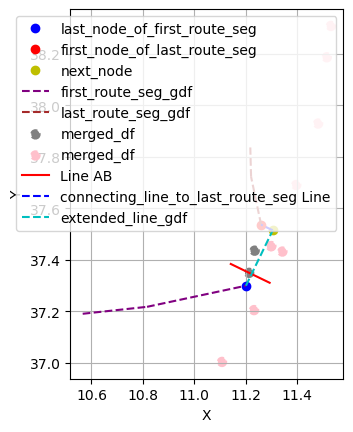

In [44]:
# Plotting
fig, ax = plt.subplots()
#segment = LineString([(11.14119, 37.38447), (11.29208, 37.31145)])
next_node = Point(end_node_x, end_node_y)
# Plot points
ax.plot(*last_node_of_first_route_seg.xy, 'bo', label='last_node_of_first_route_seg')
ax.plot(*first_node_of_last_route_seg.xy, 'ro', label='first_node_of_last_route_seg')
ax.plot(*next_node.xy, 'yo', label='next_node')
#ax.plot(*point_B.xy, 'ro', label='Point B')

first_route_seg_gdf.plot(ax=ax, color = 'purple', linestyle='dashed', label= 'first_route_seg_gdf', linewidth = 1.5)
last_route_seg_gdf.plot(ax=ax, color = 'brown', linestyle='dashed', label= 'last_route_seg_gdf', linewidth = 1.5)
merged_df.plot(ax=ax, color = 'gray', linestyle='dashed', label= 'merged_df', linewidth = 1.5)
#pp_route_gdf.plot(ax=ax, color = 'pink', linestyle='dashed', label= 'merged_df', linewidth = 1.5)
# Plot lines
ax.plot(*segment.xy, 'r-', label='Line AB')
ax.plot(*connecting_line_to_last_route_seg.xy, 'b-', linestyle='dashed',label='connecting_line_to_last_route_seg Line')
extended_line_gdf.plot(ax=ax, color = 'c', linestyle='dashed', label= 'extended_line_gdf', linewidth = 1.5)
# Set aspect ratio to be equal
ax.set_aspect('equal', adjustable='box')

# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

# Show plot
plt.grid()
plt.show()

In [62]:
filename = "/ROUTE/min_time_route_postprocessed.json"
import json 

with open(filename) as f:
    data = json.load(f)
lats_per_step.clear()
lons_per_step.clear()


point_list = data['features']
count = len(point_list)
print(count)
lats_per_step = [None] * count
lons_per_step = [None] *count
timestamp = [None] *count
starttime_per_step = [None] *count
for ipoint in range(0, count):
    coord_pair = point_list[ipoint]['geometry']['coordinates']
    print(ipoint)
    print(coord_pair)
    lats_per_step[ipoint] = coord_pair[1]
    lons_per_step[ipoint] = coord_pair[0]
    timestamp[ipoint] = ipoint
    starttime_per_step[ipoint] = ipoint
my_dict = {'lons_per_step' :lons_per_step,'lats_per_step' : lats_per_step}
print(my_dict)
pp_route_df = pd.DataFrame(my_dict)
pp_route_df
pp_route_df.columns = ['lons_per_step', 'lats_per_step']
geometry_route = gpd.points_from_xy(pp_route_df.lons_per_step, pp_route_df.lats_per_step, crs="EPSG:4326")
pp_route_gdf = gpd.GeoDataFrame(  crs='epsg:4326', geometry=geometry_route )
pp_route_gdf
route_segments__pp_gdf = create_route_segments()


9
0
[11.107, 37.004]
1
[11.231483672946569, 37.20521402760291]
2
[11.341553031692367, 37.43264096370004]
3
[11.297911576447866, 37.45376241516894]
4
[11.297911576447866, 37.45376241516894]
5
[11.395357202516575, 37.6910970467879]
6
[11.480319919127542, 37.92981813760698]
7
[11.513972965529051, 38.18710739100767]
8
[11.53, 38.309]
{'lons_per_step': [11.107, 11.231483672946569, 11.341553031692367, 11.297911576447866, 11.297911576447866, 11.395357202516575, 11.480319919127542, 11.513972965529051, 11.53], 'lats_per_step': [37.004, 37.20521402760291, 37.43264096370004, 37.45376241516894, 37.45376241516894, 37.6910970467879, 37.92981813760698, 38.18710739100767, 38.309]}


In [65]:
filename = "/ROUTE/min_time_route.json"
import json 

with open(filename) as f:
    data = json.load(f)
lats_per_step.clear()
lons_per_step.clear()


point_list = data['features']
count = len(point_list)
print(count)
lats_per_step = [None] * count
lons_per_step = [None] *count
timestamp = [None] *count
starttime_per_step = [None] *count
for ipoint in range(0, count):
    coord_pair = point_list[ipoint]['geometry']['coordinates']
    print(ipoint)
    print(coord_pair)
    lats_per_step[ipoint] = coord_pair[1]
    lons_per_step[ipoint] = coord_pair[0]
    timestamp[ipoint] = ipoint
    starttime_per_step[ipoint] = ipoint
my_dict = {'lons_per_step' :lons_per_step,'lats_per_step' : lats_per_step}
print(my_dict)
pp_route_df = pd.DataFrame(my_dict)
pp_route_df
pp_route_df.columns = ['lons_per_step', 'lats_per_step']
geometry_route = gpd.points_from_xy(pp_route_df.lons_per_step, pp_route_df.lats_per_step, crs="EPSG:4326")
pp_route_gdf_min = gpd.GeoDataFrame(  crs='epsg:4326', geometry=geometry_route )
pp_route_gdf_min
route_segments__pp_gdf_min = create_route_segments()

7
0
[11.107, 37.004]
1
[11.231483672946569, 37.20521402760291]
2
[11.297911576447866, 37.45376241516894]
3
[11.395357202516575, 37.6910970467879]
4
[11.480319919127542, 37.92981813760698]
5
[11.513972965529051, 38.18710739100767]
6
[11.53, 38.309]
{'lons_per_step': [11.107, 11.231483672946569, 11.297911576447866, 11.395357202516575, 11.480319919127542, 11.513972965529051, 11.53], 'lats_per_step': [37.004, 37.20521402760291, 37.45376241516894, 37.6910970467879, 37.92981813760698, 38.18710739100767, 38.309]}


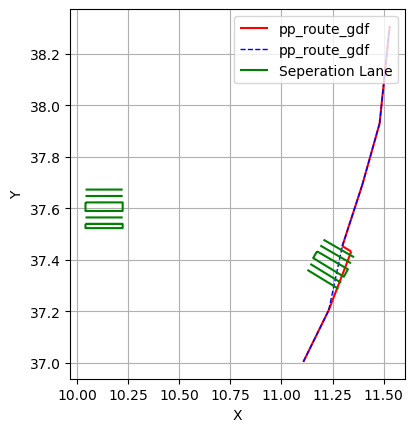

In [69]:

fig, ax = plt.subplots()
route_segments__pp_gdf.plot(ax=ax, color = 'red', label= 'pp_route_gdf', linewidth = 1.5)
route_segments__pp_gdf_min.plot(ax=ax, color = 'blue', label= 'pp_route_gdf', linewidth = 1, linestyle = "--")
#plt.plot(pp_route_gdf., y_values, linewidth = 5, linestyle = "--", color = "green")
gdf_ways.plot(ax=ax,  color='g',label='Seperation Lane',  linewidth=1.5)
# Set labels and legend
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()

# Show plot
plt.grid()
plt.show()

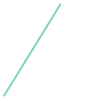

In [32]:
intersecting_route_seg_geom = LineString([(11.231, 37.205), (11.107, 37.004)])
intersecting_route_seg_geom

In [33]:
separation_lanes_data_gdf

,id,version,user_id,tstamp,changeset_id,tags,nodes,linestring,bbox,geom
0,308520793,1,554973,2014-10-19 05:28:12,26186018,{'seamark:type': 'separation_lane'},"[3137900431, 3137899926]",0102000020E610000002000000453A4DB0494826401A13...,0103000020E61000000100000005000000453A4DB04948...,"LINESTRING (11.14119 37.38447, 11.29208 37.31145)"
1,308520797,1,554973,2014-10-19 05:28:12,26186018,{'seamark:type': 'separation_lane'},"[3137900430, 3137900435]",0102000020E6100000020000001B193FE834AE2640030D...,0103000020E61000000100000005000000BD676ECF3D61...,"LINESTRING (11.34025 37.38724, 11.18992 37.45617)"
2,898527699,1,554973,2021-01-22 16:13:50,97985515,{'seamark:type': 'separation_lane'},"[8349670162, 8349670163]",0102000020E61000000200000072B8A008F31424400FB4...,0103000020E6100000010000000500000072B8A008F314...,"LINESTRING (10.04092 37.56513, 10.22284 37.56515)"
3,898527700,1,554973,2021-01-22 16:13:50,97985515,{'seamark:type': 'separation_lane'},"[8349670160, 8349670161]",0102000020E6100000020000006A238DC00E72244022E4...,0103000020E6100000010000000500000031BE1E02FD14...,"LINESTRING (10.22277 37.64852, 10.04099 37.64844)"


In [34]:

intersecting_route_seg_gdf = gpd.GeoDataFrame(geometry=[intersecting_route_seg_geom],crs=separation_lanes_data_gdf.crs)
intersecting_separation_lanes = gpd.overlay(intersecting_route_seg_gdf, separation_lanes_data_gdf,
                                       how='union', keep_geom_type=False)
intersecting_separation_lanes
#if len(intersecting_separation_lanes) == 0:


C:\Users\Maneesha\miniconda3\envs\mgr_python_3_9\lib\site-packages\geopandas\tools\overlay.py:142: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dfunion = pd.concat([dfinter, dfsym], ignore_index=True, sort=False)


,id,version,user_id,tstamp,changeset_id,tags,nodes,linestring,bbox,geometry
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"LINESTRING (11.23100 37.20500, 11.10700 37.00400)"
1,308520793.0,1.0,554973.0,2014-10-19 05:28:12,26186018.0,{'seamark:type': 'separation_lane'},"[3137900431, 3137899926]",0102000020E610000002000000453A4DB0494826401A13...,0103000020E61000000100000005000000453A4DB04948...,"LINESTRING (11.14119 37.38447, 11.29208 37.31145)"
2,308520797.0,1.0,554973.0,2014-10-19 05:28:12,26186018.0,{'seamark:type': 'separation_lane'},"[3137900430, 3137900435]",0102000020E6100000020000001B193FE834AE2640030D...,0103000020E61000000100000005000000BD676ECF3D61...,"LINESTRING (11.34025 37.38724, 11.18992 37.45617)"
3,898527699.0,1.0,554973.0,2021-01-22 16:13:50,97985515.0,{'seamark:type': 'separation_lane'},"[8349670162, 8349670163]",0102000020E61000000200000072B8A008F31424400FB4...,0103000020E6100000010000000500000072B8A008F314...,"LINESTRING (10.04092 37.56513, 10.22284 37.56515)"
4,898527700.0,1.0,554973.0,2021-01-22 16:13:50,97985515.0,{'seamark:type': 'separation_lane'},"[8349670160, 8349670161]",0102000020E6100000020000006A238DC00E72244022E4...,0103000020E6100000010000000500000031BE1E02FD14...,"LINESTRING (10.22277 37.64852, 10.04099 37.64844)"
